# Importign required modules

In [16]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [17]:
# Train transformations
train_transforms = transforms.Compose([
    transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

# Test transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])


In [18]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [19]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

SEED = 1
# To reproduce the same results across the sessions
torch.manual_seed(SEED)

if cuda:
  torch.cuda.manual_seed(SEED)
  dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True)
else:
  dataloader_args = dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Model

In [20]:
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
        ) # output_size = 26, RF (3x3)


        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 24,  RF (5x5)

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
        ) # output_size = 24, RF (7x7)


        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12, RF (8x8)


        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
        ) # output_size = 10, RF (12x12)

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
        ) # output_size = 8, RF (16x16)

        self.pool2 = nn.MaxPool2d(2, 2) # output_size = 4,  RF (18x18)

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 2, RF (26x26)


        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=2)
        ) # output_size = 1, RF (26x26)

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        )


    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.pool2(x)
        x = self.convblock6(x)
        x = self.gap(x)
        x = self.convblock7(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [21]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
            Conv2d-4            [-1, 8, 24, 24]             576
              ReLU-5            [-1, 8, 24, 24]               0
       BatchNorm2d-6            [-1, 8, 24, 24]              16
           Dropout-7            [-1, 8, 24, 24]               0
            Conv2d-8            [-1, 8, 24, 24]             576
              ReLU-9            [-1, 8, 24, 24]               0
      BatchNorm2d-10            [-1, 8, 24, 24]              16
        MaxPool2d-11            [-1, 8, 12, 12]               0
           Conv2d-12           [-1, 16, 10, 10]           1,152
             ReLU-13           [-1, 16, 10, 10]               0
      BatchNorm2d-14           [-1, 16,

In [22]:
from tqdm import tqdm

# Aggregate loss and accuracy
train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)

  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    # get batch data
    data, target = data.to(device), target.to(device)

    # Reset all gradients to zero
    optimizer.zero_grad()

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Do calculate the grads in dackpropagation
    loss.backward()

    # Update the model weights
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # Aggregate batch loss
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    # Update total test data loss
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

# Training & Testing

In [23]:
from torch.optim.lr_scheduler import StepLR

# Creat the mode and move it to CUDA
model = Net().to(device)

# Using stochastic gradient descent method for optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

EPOCHS = 15
for epoch in range(EPOCHS):
    print(f"EPOCH: {epoch}")
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.051220107823610306 Batch_id=468 Accuracy=92.39: 100%|██████████| 469/469 [00:29<00:00, 16.06it/s]



Test set: Average loss: 0.0773, Accuracy: 9788/10000 (97.88%)

EPOCH: 1


Loss=0.05591018870472908 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:23<00:00, 20.08it/s]



Test set: Average loss: 0.0370, Accuracy: 9897/10000 (98.97%)

EPOCH: 2


Loss=0.04485161975026131 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:23<00:00, 20.13it/s]



Test set: Average loss: 0.0327, Accuracy: 9910/10000 (99.10%)

EPOCH: 3


Loss=0.0167007427662611 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:22<00:00, 20.60it/s]



Test set: Average loss: 0.0286, Accuracy: 9921/10000 (99.21%)

EPOCH: 4


Loss=0.04081930220127106 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:23<00:00, 19.80it/s]



Test set: Average loss: 0.0289, Accuracy: 9916/10000 (99.16%)

EPOCH: 5


Loss=0.010425739921629429 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:22<00:00, 20.54it/s]



Test set: Average loss: 0.0274, Accuracy: 9926/10000 (99.26%)

EPOCH: 6


Loss=0.0269684586673975 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:22<00:00, 20.41it/s]



Test set: Average loss: 0.0224, Accuracy: 9935/10000 (99.35%)

EPOCH: 7


Loss=0.03845670074224472 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:22<00:00, 20.65it/s]



Test set: Average loss: 0.0213, Accuracy: 9940/10000 (99.40%)

EPOCH: 8


Loss=0.05245872959494591 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:22<00:00, 21.27it/s]



Test set: Average loss: 0.0226, Accuracy: 9933/10000 (99.33%)

EPOCH: 9


Loss=0.01511185523122549 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:21<00:00, 22.03it/s]



Test set: Average loss: 0.0246, Accuracy: 9918/10000 (99.18%)

EPOCH: 10


Loss=0.005581547040492296 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:21<00:00, 21.92it/s]



Test set: Average loss: 0.0200, Accuracy: 9937/10000 (99.37%)

EPOCH: 11


Loss=0.03456810489296913 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:21<00:00, 21.70it/s]



Test set: Average loss: 0.0197, Accuracy: 9939/10000 (99.39%)

EPOCH: 12


Loss=0.010609718970954418 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:21<00:00, 21.56it/s]



Test set: Average loss: 0.0216, Accuracy: 9939/10000 (99.39%)

EPOCH: 13


Loss=0.025109553709626198 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:21<00:00, 21.42it/s]



Test set: Average loss: 0.0192, Accuracy: 9942/10000 (99.42%)

EPOCH: 14


Loss=0.017285576090216637 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:22<00:00, 20.99it/s]



Test set: Average loss: 0.0230, Accuracy: 9937/10000 (99.37%)



Text(0.5, 1.0, 'Test Accuracy')

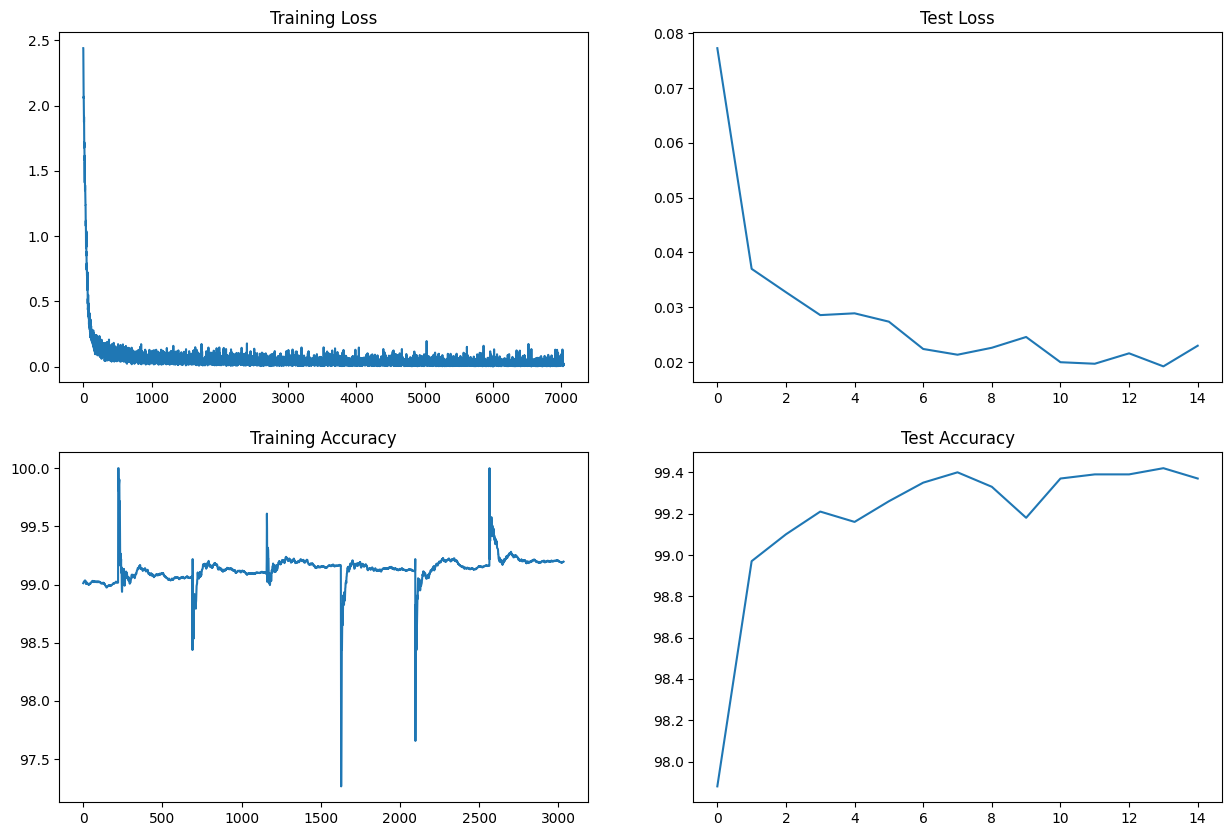

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt

t = [t_items.item() for t_items in train_losses]

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

# Iteration 2_2
---
## Target:
*   Applying data augmentation, a random rotation to the input image within the range of -7.0 to 7.0 degrees.
*   Applying LR scheduler with a step size as 6 and gamma as 0.1

## Results:
*   Total params: 7,288
*   Best Training Accuracy: 99.20%
*   Best Test Accuracy: 99.42%

## Analysis:
*   Touched 99.4% for the first time in the 7th epoch. However, it again crossed the target value only in the penultimate epoch, though the value hovered around it for most of the time.
*   The model is a bit under fitting.
*   Applied dropouts randomly at two locations with a learning rate of 0.1.
*   Surprisingly, applying dropouts at all the locations did not help to reach the targeted test accuracy. So, I applied them only at two locations.
*   Tried to add an extra layer, keeping the overall count under 8K, but that also did not help much. So, I removed that too.
*   Varying the learning rate in the case of dropouts and the step size and gamma in the case of the LR scheduler also did not produce better results than this.
*   I am able to reach the targeted test accuracy only with this configuration.